# Project Goal

The goal of this project is to **analyze customer ordering behavior and identify factors that contribute to cart abandonment** within the **MyCoke360** platform — Coca-Cola’s online ordering system for business customers.

MyCoke360 allows Coca-Cola’s B2B clients — including restaurants, retailers, distributors, and institutions — to place and manage orders digitally.  
Despite high engagement on the platform, many customers begin the purchase process but fail to complete their orders.

This analysis aims to:
- Quantify **cart abandonment rates**, and  
- Uncover **behavioral and operational drivers** behind this issue.

By linking **Google Analytics (GA)** event data (user interactions) with **order**, **visit**, and **sales** records, we seek to generate actionable insights that will help:
- Reduce lost sales opportunities, and  
- Improve the overall **conversion efficiency** of the MyCoke360 platform.


# Introduction

The goal of this project is to analyze customer ordering behavior and identify factors that contribute to cart abandonment within the **MyCoke360** platform — Coca-Cola’s online ordering system for business customers.

MyCoke360 serves Coca-Cola’s B2B clients — including restaurants, retailers, distributors, and institutions — enabling them to place and manage orders digitally. Despite strong platform engagement, a significant number of customers begin the checkout process but fail to complete their orders. This leads to lost sales opportunities and reduced conversion efficiency.

To address this issue, we aim to develop a predictive model to classify whether a customer will abandon their cart (Class 1) or complete the checkout process (Class 0). We apply and evaluate multiple machine learning models including **Logistic Regression**, **XGBoost**, and **CatBoost**.

Our primary objectives are:

- To compare the performance of different classification models in predicting cart abandonment.
- To identify the most important behavioral and contextual factors influencing cart abandonment.
- To evaluate class-specific metrics—especially for the minority class (abandonment)—given the business importance of identifying and targeting such users.

We use a combination of **accuracy**, **ROC-AUC**, **precision**, **recall**, **F1 scores**, and **confusion matrices** to assess model performance both overall and by class.

By the end of this analysis, we aim to recommend the most effective model for production deployment and provide actionable insights into customer behavior that can guide interventions like reminders, retargeting, or personalized promotions.

# Data Preparation

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [97]:
# lets bring in our final table csv first to work off
final_with_ga = pd.read_csv('final_with_ga_updated.csv')

final_with_ga.head()

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,num_add_to_cart_events,total_items_added_to_cart,purchases,button_clicks,total_events,ABANDONED_CART,SALES_OFFICE,...,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,CREATED_DATE_EST,CREATED_DATE_UTC,ORDER_QUANTITY,ORDER_TYPE,MATERIAL_ID,ORDER_EXISTS
0,500245685,2025-02-17,2025-02-24,1,37,1,41,261,1,G111,...,OFS,Monday,7,5:00:00 PM,NaN,NaN,NaN,NaN,NaN,0
1,500245685,2025-03-17,2025-03-24,1,37,1,11,44,1,G111,...,OFS,Monday,7,5:00:00 PM,NaN,NaN,NaN,NaN,NaN,0
2,500245685,2025-04-14,2025-04-21,1,37,1,7,55,1,G111,...,OFS,Monday,7,5:00:00 PM,NaN,NaN,NaN,NaN,NaN,0
3,500245685,2025-04-28,2025-05-05,1,37,1,4,38,1,G111,...,OFS,Monday,7,5:00:00 PM,NaN,NaN,NaN,NaN,NaN,0
4,500245738,2024-11-20,2024-11-27,1,397,1,1,27,0,G111,...,OFS,Wednesday,7,5:00:00 PM,2024-11-22,2024-11-22 18:46:16+00:00,13.0,MYCOKE360,"[np.float64(129254.0), np.float64(114756.0), n...",1


In [99]:
# null count for columns
final_with_ga.isnull().sum()

CUSTOMER_ID                      0
ANCHOR_DATE                      0
NEXT_ANCHOR_SAME_WD              0
num_add_to_cart_events           0
total_items_added_to_cart        0
purchases                        0
button_clicks                    0
total_events                     0
ABANDONED_CART                   0
SALES_OFFICE                     0
SALES_OFFICE_DESC                0
DISTRIBUTION_MODE                0
SHIPPING_CONDITIONS_DESC         0
FREQUENCY_CLEAN              13107
DISTRIBUTION_MODE_DESC           0
WEEK_DAY_OF_ANCHOR_DATE          0
WINDOW_FREQUENCY                 0
CUTOFFTIME__C                    0
CREATED_DATE_EST              2853
CREATED_DATE_UTC              2853
ORDER_QUANTITY                2853
ORDER_TYPE                    2853
MATERIAL_ID                   2853
ORDER_EXISTS                     0
dtype: int64

In [101]:
# lets see the values for frequency clean
master['SHIPPING_CONDITIONS_DESC'].value_counts()

SHIPPING_CONDITIONS_DESC
48 Hours             18620
24 Hours               798
72 Hours                44
Dropsite 48 Hours       29
Dropsite 24 Hours        1
Name: count, dtype: int64

In [103]:
def extract_hours(desc):
  if '24' in desc:
    return 24
  elif '48' in desc:
    return 48
  elif '72' in desc:
    return 72
  else:
    return None

final_with_ga['SHIPPING_CONDITIONS'] = final_with_ga['SHIPPING_CONDITIONS_DESC'].apply(extract_hours)

In [105]:
# lets see the values for window frequency
final_with_ga['WINDOW_FREQUENCY'].value_counts()

WINDOW_FREQUENCY
7     12787
14     3449
28     3233
21       23
Name: count, dtype: int64

In [107]:
final_with_ga['WEEK_DAY_OF_ANCHOR_DATE'].value_counts()

WEEK_DAY_OF_ANCHOR_DATE
Wednesday    4484
Thursday     3993
Tuesday      3809
Monday       3725
Friday       3475
Sunday          6
Name: count, dtype: int64

In [109]:
# drop frequency clean
final_with_ga.drop('FREQUENCY_CLEAN', axis=1, inplace=True)

In [111]:
# row count for a customer
final_with_ga[final_with_ga['CUSTOMER_ID'] == 500245738].shape[0]


25

In [113]:
# filter for customer 500245738
final_with_ga[final_with_ga['CUSTOMER_ID'] == 500245738 ]

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,num_add_to_cart_events,total_items_added_to_cart,purchases,button_clicks,total_events,ABANDONED_CART,SALES_OFFICE,...,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,CREATED_DATE_EST,CREATED_DATE_UTC,ORDER_QUANTITY,ORDER_TYPE,MATERIAL_ID,ORDER_EXISTS,SHIPPING_CONDITIONS
4,500245738,2024-11-20,2024-11-27,1,397,1,1,27,0,G111,...,Wednesday,7,5:00:00 PM,2024-11-22,2024-11-22 18:46:16+00:00,13.0,MYCOKE360,"[np.float64(129254.0), np.float64(114756.0), n...",1,48
5,500245738,2024-11-27,2024-12-04,1,865,1,0,18,0,G111,...,Wednesday,7,5:00:00 PM,2024-11-27,2024-11-28 02:46:16+00:00,34.0,MYCOKE360,"[np.float64(158490.0), np.float64(156090.0), n...",1,48
6,500245738,2024-12-04,2024-12-11,3,1335,2,3,53,0,G111,...,Wednesday,7,5:00:00 PM,2024-12-04,2024-12-04 22:02:03+00:00,45.0,MYCOKE360,"[np.float64(117641.0), np.float64(121751.0), n...",1,48
7,500245738,2024-12-11,2024-12-18,1,757,1,0,19,0,G111,...,Wednesday,7,5:00:00 PM,2024-12-12,2024-12-13 01:44:02+00:00,37.0,MYCOKE360,"[np.float64(157128.0), np.float64(102604.0), n...",1,48
8,500245738,2024-12-18,2024-12-25,2,902,1,2,26,0,G111,...,Wednesday,7,5:00:00 PM,2024-12-23,2024-12-23 22:36:08+00:00,33.0,MYCOKE360,"[np.float64(117641.0), np.float64(114756.0), n...",1,48
9,500245738,2025-01-08,2025-01-15,2,1298,2,6,82,0,G111,...,Wednesday,7,5:00:00 PM,2025-01-08,2025-01-08 19:21:06+00:00,59.0,MYCOKE360,"[np.float64(156090.0), np.float64(157128.0), n...",1,48
10,500245738,2025-01-15,2025-01-22,1,721,1,0,21,0,G111,...,Wednesday,7,5:00:00 PM,2025-01-20,2025-01-20 22:42:02+00:00,24.0,MYCOKE360,"[np.float64(117635.0), np.float64(117641.0), n...",1,48
11,500245738,2025-01-22,2025-01-29,1,901,1,4,42,0,G111,...,Wednesday,7,5:00:00 PM,2025-01-22,2025-01-23 00:04:07+00:00,43.0,MYCOKE360,"[np.float64(121750.0), np.float64(128092.0), n...",1,48
12,500245738,2025-01-29,2025-02-05,2,1010,1,1,31,0,G111,...,Wednesday,7,5:00:00 PM,2025-01-29,2025-01-29 22:02:48+00:00,37.0,MYCOKE360,"[np.float64(117635.0), np.float64(129254.0), n...",1,48
13,500245738,2025-02-05,2025-02-12,1,829,1,0,18,0,G111,...,Wednesday,7,5:00:00 PM,2025-02-10,2025-02-10 23:40:20+00:00,38.0,MYCOKE360,"[np.float64(117603.0), np.float64(102603.0), n...",1,48


In [115]:
# lets check the number of abandoned carts for the customer
final_with_ga[(final_with_ga['CUSTOMER_ID'] == 500245738) & (final_with_ga['WINDOW_FREQUENCY'] == 'Abandoned Cart')].shape[0]

0

In [117]:
material = pd.read_csv("material.csv")
print(material.shape)

material_clean = material.copy()
# Convert everything to lowercase
material_clean["PACK_SIZE_DESC"] = material_clean["PACK_SIZE_DESC"].astype(str).str.lower()

# 1 gallon = 128 oz
def to_oz(size):
    if "gallon" in size:
        num = float(size.split()[0])
        return num * 128
    elif "oz" in size:
        num = float(size.split()[0])
        return num
    else:
        return None

material_clean["PACK_SIZE_OZ"] = material_clean["PACK_SIZE_DESC"].apply(to_oz)
material_clean = material_clean.drop(columns=['PACK_SIZE_DESC'])
material_clean = material_clean.fillna(0)
print(material_clean.head())
print(material_clean.shape)
# Check for missing values
print("Missing values per column:")
print(material_clean.isnull().sum())

(1252, 6)
   MATERIAL_ID          PACK_TYPE_DESC   TRADE_MARK_DESC    FLAVOUR_DESC  \
0       125522  Plastic Bottle - Other  Oliver Originals  Salted Caramel   
1       116974           Styrofoam Lid         Sunny Sip    Passionfruit   
2       113144              Bag-In-Box             Sam's       Bubblegum   
3       410256            Aluminum Can     Jack's Juices      Cappuccino   
4       146980            Aluminum Can  Oliver Originals   Vanilla Latte   

     BEV_CAT_DESC  PACK_SIZE_OZ  
0  CORE SPARKLING          20.0  
1               0          24.0  
2  JUICES/NECTARS         320.0  
3  CORE SPARKLING          12.0  
4  CORE SPARKLING          16.0  
(1252, 6)
Missing values per column:
MATERIAL_ID        0
PACK_TYPE_DESC     0
TRADE_MARK_DESC    0
FLAVOUR_DESC       0
BEV_CAT_DESC       0
PACK_SIZE_OZ       0
dtype: int64


In [119]:
sales = pd.read_csv("sales.csv")
print(sales.head())

   CUSTOMER_ID POSTING_DATE  MATERIAL_ID  GROSS_PROFIT_DEAD_NET  \
0    600055574    7/17/2024       144775                 130.68   
1    600055574    7/17/2024       156082                  37.42   
2    501438989    7/17/2024       144775                  41.84   
3    600055574    7/17/2024       154914                  53.24   
4    600055574    7/17/2024       156182                 110.30   

   PHYSICAL_VOLUME  NSI_DEAD_NET  
0             22.0        737.00  
1              6.0        105.42  
2              4.0        166.40  
3              4.0        123.88  
4             10.0        348.80  


In [121]:
operating_hours = pd.read_csv("operating_hours.csv")
print(operating_hours.head())
print(operating_hours.shape)

operating_clean = operating_hours.copy()
# Map frequency descriptions to standardized codes
map_frequency = {
    'Every Week': '01',
    'Every 2 Weeks': '02',
    'Every 3 Weeks': '03',
    'Every 4 Weeks': '04'
}
operating_clean['FREQUENCY_CLEAN'] = operating_clean['FREQUENCY'].map(map_frequency)
operating_clean = operating_clean.drop(columns= ['FREQUENCY'])
print(operating_clean['FREQUENCY_CLEAN'].value_counts(dropna=False))
operating_clean = operating_clean.rename(columns={'CUSTOMER_NUMBER' : 'CUSTOMER_ID'})
print(operating_clean.shape)
# Check for missing values
print("Missing values per column:")
null_counts = operating_clean.isnull().sum()
print(null_counts)

   CUSTOMER_NUMBER      FREQUENCY DELIVERY_ANCHOR_DAY CALLING_ANCHOR_DATE
0        600069597  Every 4 Weeks              Friday            2/5/2025
1        501562126  Every 4 Weeks             Tuesday           1/26/2025
2        500324496  Every 4 Weeks             Tuesday            2/2/2025
3        600259095     Every Week           Wednesday            2/4/2025
4        501072497     Every Week             Tuesday          11/17/2024
(6202, 4)
FREQUENCY_CLEAN
04    2562
01    2140
02    1489
03      11
Name: count, dtype: int64
(6202, 4)
Missing values per column:
CUSTOMER_ID            0
DELIVERY_ANCHOR_DAY    0
CALLING_ANCHOR_DATE    0
FREQUENCY_CLEAN        0
dtype: int64


In [123]:
sales_material = pd.merge(sales, material_clean, on='MATERIAL_ID', how='left')
print(sales_material.shape)
print(sales_material.isna().sum())
sales_material.fillna(0, inplace=True)

(499787, 11)
CUSTOMER_ID              0
POSTING_DATE             0
MATERIAL_ID              0
GROSS_PROFIT_DEAD_NET    0
PHYSICAL_VOLUME          0
NSI_DEAD_NET             0
PACK_TYPE_DESC           4
TRADE_MARK_DESC          4
FLAVOUR_DESC             4
BEV_CAT_DESC             4
PACK_SIZE_OZ             4
dtype: int64


In [127]:
sales_material_op = pd.merge(operating_clean, sales_material, on = 'CUSTOMER_ID', how='left')
print(sales_material_op.shape)
print(sales_material_op.isna().sum())
sales_material_op.fillna(0, inplace=True)
sales_material_op.to_csv("sales_material_op.csv", index=False)

(497093, 14)
CUSTOMER_ID                0
DELIVERY_ANCHOR_DAY        0
CALLING_ANCHOR_DATE        0
FREQUENCY_CLEAN            0
POSTING_DATE             486
MATERIAL_ID              486
GROSS_PROFIT_DEAD_NET    486
PHYSICAL_VOLUME          486
NSI_DEAD_NET             486
PACK_TYPE_DESC           486
TRADE_MARK_DESC          486
FLAVOUR_DESC             486
BEV_CAT_DESC             486
PACK_SIZE_OZ             486
dtype: int64


# Bringing in Sales/Material/Op Data

In [130]:
# lets bring in our final table csv first to work off

smo = pd.read_csv('sales_material_op.csv')

smo.head()

,CUSTOMER_ID,DELIVERY_ANCHOR_DAY,CALLING_ANCHOR_DATE,FREQUENCY_CLEAN,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI_DEAD_NET,PACK_TYPE_DESC,TRADE_MARK_DESC,FLAVOUR_DESC,BEV_CAT_DESC,PACK_SIZE_OZ
0,600069597,Friday,2/5/2025,4,9/4/2024,129252.0,14.88,2.0,39.84,Plastic Bottle - Other,Pete's Popcorn,Vanilla Raspberry,PACKAGED WATER (PLAIN & ENRICHED),33.8
1,600069597,Friday,2/5/2025,4,6/12/2024,132532.0,38.57,3.0,60.48,Plastic Bottle - Contour,Oliver Originals,Vanilla Latte,CORE SPARKLING,0.0
2,600069597,Friday,2/5/2025,4,6/26/2024,115586.0,30.85,4.0,62.32,Aluminum Can,Jack's Juices,Cappuccino,CORE SPARKLING,12.0
3,600069597,Friday,2/5/2025,4,6/26/2024,116307.0,33.41,4.0,62.32,Aluminum Can,Fizz Factory,Banana Nut,CORE SPARKLING,12.0
4,600069597,Friday,2/5/2025,4,7/24/2024,132545.0,34.40,3.0,60.48,Plastic Bottle - Other,Fizz Factory,Banana Nut,CORE SPARKLING,0.0


In [132]:
# look at column names
smo.columns

Index(['CUSTOMER_ID', 'DELIVERY_ANCHOR_DAY', 'CALLING_ANCHOR_DATE',
       'FREQUENCY_CLEAN', 'POSTING_DATE', 'MATERIAL_ID',
       'GROSS_PROFIT_DEAD_NET', 'PHYSICAL_VOLUME', 'NSI_DEAD_NET',
       'PACK_TYPE_DESC', 'TRADE_MARK_DESC', 'FLAVOUR_DESC', 'BEV_CAT_DESC',
       'PACK_SIZE_OZ'],
      dtype='object')

In [134]:
# unique calling anchor dates for customer
smo[smo['CUSTOMER_ID'] == 500245738]['CALLING_ANCHOR_DATE'].unique()

array(['11/18/2024'], dtype=object)

In [136]:
# unique delivery anchor dates for customer
smo[smo['CUSTOMER_ID'] == 500245738]['DELIVERY_ANCHOR_DAY'].unique()

array(['Wednesday'], dtype=object)

In [138]:
# row count for the customer
smo[smo['CUSTOMER_ID'] == 500245738].shape[0]

485

In [140]:
# unique row count
unique_count = smo[smo['CUSTOMER_ID'] == 500245738]['MATERIAL_ID'].nunique()
unique_count

31

In [142]:
# rows where customer is 500245738 and material id
smo[(smo['CUSTOMER_ID'] == 500245738) & (smo['MATERIAL_ID'] == 158489.0)]

,CUSTOMER_ID,DELIVERY_ANCHOR_DAY,CALLING_ANCHOR_DATE,FREQUENCY_CLEAN,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI_DEAD_NET,PACK_TYPE_DESC,TRADE_MARK_DESC,FLAVOUR_DESC,BEV_CAT_DESC,PACK_SIZE_OZ
402483,500245738,Wednesday,11/18/2024,1,5/7/2025,158489.0,14.34,2.0,46.80,Aluminum Can,Bobby's Bottles,Blueberry Acai,ENERGY DRINKS,16.0
402614,500245738,Wednesday,11/18/2024,1,4/23/2025,158489.0,14.34,2.0,46.80,Aluminum Can,Bobby's Bottles,Blueberry Acai,ENERGY DRINKS,16.0
402617,500245738,Wednesday,11/18/2024,1,5/14/2025,158489.0,14.34,2.0,46.80,Aluminum Can,Bobby's Bottles,Blueberry Acai,ENERGY DRINKS,16.0
402650,500245738,Wednesday,11/18/2024,1,11/15/2024,158489.0,13.90,2.0,45.04,Aluminum Can,Bobby's Bottles,Blueberry Acai,ENERGY DRINKS,16.0
402773,500245738,Wednesday,11/18/2024,1,11/26/2024,158489.0,13.90,2.0,45.04,Aluminum Can,Bobby's Bottles,Blueberry Acai,ENERGY DRINKS,16.0
402776,500245738,Wednesday,11/18/2024,1,12/17/2024,158489.0,13.90,2.0,45.04,Aluminum Can,Bobby's Bottles,Blueberry Acai,ENERGY DRINKS,16.0
402795,500245738,Wednesday,11/18/2024,1,4/30/2025,158489.0,14.34,2.0,46.80,Aluminum Can,Bobby's Bottles,Blueberry Acai,ENERGY DRINKS,16.0


In [144]:
# column type for posting date
smo['POSTING_DATE'].dtype

dtype('O')

# Joining the two tables

Turns out the join is very difficult because of all the separate rows for materials in the smo table. And then the final table structure cannot be altered too much because it would affect the abandonment column which we do not want. Therefore, we are going to aggregate the transactions per window to create some new columns and then join them back to the final table

In [148]:
smo['POSTING_DATE'] = pd.to_datetime(smo['POSTING_DATE'], errors = 'coerce')

In [150]:
# fixing the material id list
import ast

def parse_material_list(val):
    try:
        return [float(x) for x in ast.literal_eval(val)]
    except:
        return []

final_with_ga['MATERIAL_LIST'] = final_with_ga['MATERIAL_ID'].apply(parse_material_list)


In [151]:
# cross joining dataframes first
smo['_tmp'] = 1
final_with_ga['_tmp'] = 1

cross = pd.merge(smo, final_with_ga, on=['CUSTOMER_ID','_tmp'])

In [153]:
print(cross.columns)

Index(['CUSTOMER_ID', 'DELIVERY_ANCHOR_DAY', 'CALLING_ANCHOR_DATE',
       'FREQUENCY_CLEAN', 'POSTING_DATE', 'MATERIAL_ID_x',
       'GROSS_PROFIT_DEAD_NET', 'PHYSICAL_VOLUME', 'NSI_DEAD_NET',
       'PACK_TYPE_DESC', 'TRADE_MARK_DESC', 'FLAVOUR_DESC', 'BEV_CAT_DESC',
       'PACK_SIZE_OZ', '_tmp', 'ANCHOR_DATE', 'NEXT_ANCHOR_SAME_WD',
       'num_add_to_cart_events', 'total_items_added_to_cart', 'purchases',
       'button_clicks', 'total_events', 'ABANDONED_CART', 'SALES_OFFICE',
       'SALES_OFFICE_DESC', 'DISTRIBUTION_MODE', 'SHIPPING_CONDITIONS_DESC',
       'DISTRIBUTION_MODE_DESC', 'WEEK_DAY_OF_ANCHOR_DATE', 'WINDOW_FREQUENCY',
       'CUTOFFTIME__C', 'CREATED_DATE_EST', 'CREATED_DATE_UTC',
       'ORDER_QUANTITY', 'ORDER_TYPE', 'MATERIAL_ID_y', 'ORDER_EXISTS',
       'SHIPPING_CONDITIONS', 'MATERIAL_LIST'],
      dtype='object')


In [155]:
# filtering by window match
window_match = cross[
    (cross['POSTING_DATE'] >= cross['ANCHOR_DATE']) &
    (cross['POSTING_DATE'] < cross['NEXT_ANCHOR_SAME_WD']) &
    (cross.apply(lambda row: row['MATERIAL_ID_x'] in row['MATERIAL_LIST'], axis=1))
]



Now we will calculate meaningful aggregate features by customer id and order window

In [158]:
aggregated = window_match.groupby(['CUSTOMER_ID', 'ANCHOR_DATE', 'NEXT_ANCHOR_SAME_WD']).agg({
    'PHYSICAL_VOLUME': 'sum',
    'NSI_DEAD_NET': 'sum',
    'GROSS_PROFIT_DEAD_NET': 'sum',
    'MATERIAL_ID_x': 'nunique'
}).rename(columns={
    'PHYSICAL_VOLUME': 'total_volume',
    'NSI_DEAD_NET': 'total_revenue',
    'GROSS_PROFIT_DEAD_NET': 'total_profit',
    'MATERIAL_ID_x': 'unique_materials'
}).reset_index()


Now we merge it back to the master table

In [160]:
final_df = final_with_ga.merge(aggregated, on=['CUSTOMER_ID', 'ANCHOR_DATE', 'NEXT_ANCHOR_SAME_WD'], how='left')

In [161]:
final_df.head()

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,num_add_to_cart_events,total_items_added_to_cart,purchases,button_clicks,total_events,ABANDONED_CART,SALES_OFFICE,...,ORDER_TYPE,MATERIAL_ID,ORDER_EXISTS,SHIPPING_CONDITIONS,MATERIAL_LIST,_tmp,total_volume,total_revenue,total_profit,unique_materials
0,500245685,2025-02-17,2025-02-24,1,37,1,41,261,1,G111,...,NaN,NaN,0,48,[],1,NaN,NaN,NaN,NaN
1,500245685,2025-03-17,2025-03-24,1,37,1,11,44,1,G111,...,NaN,NaN,0,48,[],1,NaN,NaN,NaN,NaN
2,500245685,2025-04-14,2025-04-21,1,37,1,7,55,1,G111,...,NaN,NaN,0,48,[],1,NaN,NaN,NaN,NaN
3,500245685,2025-04-28,2025-05-05,1,37,1,4,38,1,G111,...,NaN,NaN,0,48,[],1,NaN,NaN,NaN,NaN
4,500245738,2024-11-20,2024-11-27,1,397,1,1,27,0,G111,...,MYCOKE360,"[np.float64(129254.0), np.float64(114756.0), n...",1,48,[],1,NaN,NaN,NaN,NaN


In [162]:
final_df.drop(columns=['_tmp', 'MATERIAL_LIST'], inplace=True)

In [163]:
final_df.fillna({
    'total_volume': 0,
    'total_revenue': 0,
    'total_profit': 0,
    'unique_materials': 0
}, inplace=True)

This is where we run into another problem. Due to how orders and abandonment are related, many columns in our data including the sales/material columns will perfectly predict abandonment. They will be 0 or null if abandoned and have a value if not abandoned. This makes modeling on these variables basically impossible to use when modeling abandonment.

# Modelling

## Logistic Regression

In [182]:
# logistic regression
target = 'ABANDONED_CART'

features = [
 'num_add_to_cart_events',
 'total_items_added_to_cart',
 'button_clicks',
 'total_events',
]
cats = ['DISTRIBUTION_MODE_DESC', "SALES_OFFICE_DESC", "WEEK_DAY_OF_ANCHOR_DATE", "SHIPPING_CONDITIONS"]

In [184]:
X = final_df[features + cats]
X = pd.get_dummies(X, columns=cats, drop_first=True)

Y = final_df[target]

### Model Training & Cross-Validation

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=32)

simple_log_model = LogisticRegression(class_weight='balanced', max_iter=1000)
simple_log_model.fit(X_train, Y_train)

cv = 5

scores = cross_validate(
    simple_log_model, X, Y,
    cv=cv,
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'},
    return_train_score=False
)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.90      0.58      0.71      3311
           1       0.22      0.66      0.33       588

    accuracy                           0.59      3899
   macro avg       0.56      0.62      0.52      3899
weighted avg       0.80      0.59      0.65      3899


--- ROC-AUC Score ---
ROC-AUC: 0.6566

--- CONFUSION MATRIX ---
Predicted:    0 | 1
Actual 0: 1920 | 1391
Actual 1: 202 | 386


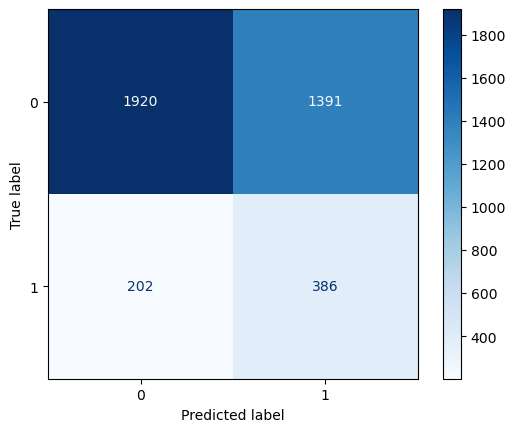

In [209]:
Y_pred = model.predict(X_test)
Y_pred_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(Y_test, Y_pred))
print("\n--- ROC-AUC Score ---")
print(f"ROC-AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}")

cm = confusion_matrix(Y_test, Y_pred) 
print("\n--- CONFUSION MATRIX ---")
print("Predicted:    0 | 1")
print(f"Actual 0: {cm[0, 0]} | {cm[0, 1]}")
print(f"Actual 1: {cm[1, 0]} | {cm[1, 1]}") 

ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

=== LOGISTIC REGRESSION RESULTS SUMMARY ===

Model Performance:
- Overall Accuracy: 59% - The model correctly classifies about 6 out of 10 cases
- ROC-AUC Score: 0.6566 - Indicates moderate ability to distinguish between classes
  (0.5 = random guessing, 1.0 = perfect classification)

Class-Specific Performance:
CLASS 0 (No Cart Abandonment):
  - Precision: 0.90 - When model predicts "no abandonment", it's correct 90% of the time
  - Recall: 0.58 - Model identifies only 58% of actual non-abandonment cases
  - F1-Score: 0.71 - Balanced measure between precision and recall
  
CLASS 1 (Cart Abandonment):
  - Precision: 0.22 - When model predicts "abandonment", it's only correct 22% of the time
  - Recall: 0.66 - Model captures 66% of actual cart abandonment cases
  - F1-Score: 0.33 - Low score indicates poor overall performance for this class

Confusion Matrix Analysis:
- True Negatives: 1920 | False Positives: 1391
- False Negatives: 202  | True Positives: 386
- The model has high false positives (1391), meaning it frequently predicts cart 
  abandonment when it doesn't actually occur

Key Observations:
1. CLASS IMBALANCE: Dataset has 3311 non-abandonment cases vs only 588 abandonment cases
   This imbalance heavily influences model performance
2. The model is BIASED toward predicting Class 0 (no abandonment) due to the imbalance
3. Low precision for Class 1 (0.22) means many false alarms - business cost implications
4. High recall for Class 1 (0.66) is good - we catch most actual abandonment cases


### ROC Curve

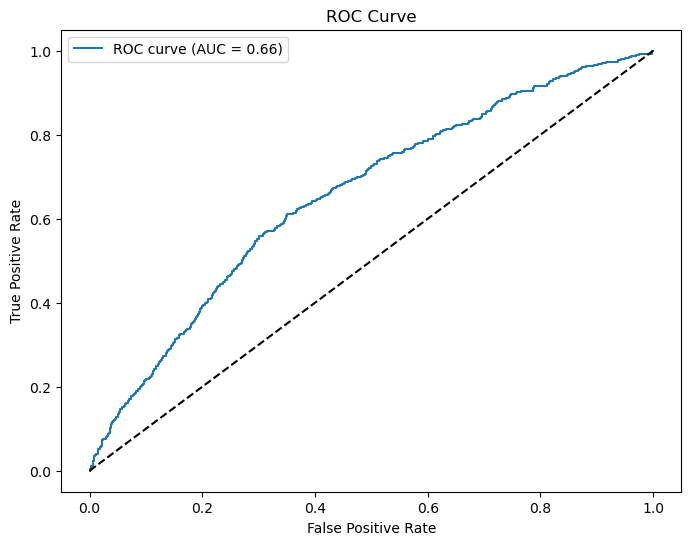

In [213]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

###  Coefficients & Feature Importance

In [217]:
#extract coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

coef_df = coef_df.sort_values('Coefficient', ascending=False)
coef_df

,Feature,Coefficient
10,DISTRIBUTION_MODE_DESC_Sideload,0.981042
18,"SALES_OFFICE_DESC_Cheyenne, WY",0.549784
8,DISTRIBUTION_MODE_DESC_OFS,0.528291
42,"SALES_OFFICE_DESC_Richfield, UT",0.490071
27,"SALES_OFFICE_DESC_Grand Junction, CO",0.464760
...,...,...
21,"SALES_OFFICE_DESC_Draper, UT",-0.417938
23,"SALES_OFFICE_DESC_Eugene, OR",-0.465870
44,"SALES_OFFICE_DESC_Show Low, AZ",-0.484251
35,"SALES_OFFICE_DESC_Ogden, UT",-0.539891


"""
=== FEATURE IMPORTANCE ANALYSIS (Logistic Regression Coefficients) ===

POSITIVE COEFFICIENTS (Increase likelihood of cart abandonment):

Top 5 Features That INCREASE Cart Abandonment Risk:
1. DISTRIBUTION_MODE_DESC_Sideload (0.98): Strongest predictor
   - Sideload distribution mode is highly associated with cart abandonment
   
2. SALES_OFFICE_DESC_Cheyenne, WY (0.55): Geographic factor
   - Customers from this location more likely to abandon carts
   
3. DISTRIBUTION_MODE_DESC_OFS (0.53): Distribution method impact
   - OFS distribution mode increases abandonment likelihood
   
4. SALES_OFFICE_DESC_Richfield, UT (0.49): Regional influence
   
5. SALES_OFFICE_DESC_Grand Junction, CO (0.47): Geographic pattern

NEGATIVE COEFFICIENTS (Decrease likelihood of cart abandonment):

Top 5 Features That DECREASE Cart Abandonment Risk:
1. SALES_OFFICE_DESC_Logan, UT (-1.30): Strongest negative predictor
   - Customers from Logan are much LESS likely to abandon carts
   
2. SALES_OFFICE_DESC_Ogden, UT (-0.54): Utah offices show lower abandonment
   
3. SALES_OFFICE_DESC_Show Low, AZ (-0.48)
   
4. SALES_OFFICE_DESC_Eugene, OR (-0.47)
   
5. SALES_OFFICE_DESC_Draper, UT (-0.42): Another Utah location

Key Insights:
- DISTRIBUTION MODE is the most important factor (Sideload has highest coefficient)
- GEOGRAPHIC LOCATION (Sales Office) plays a significant role
- Utah offices (Logan, Ogden, Draper) show LOWER cart abandonment rates
- Certain distribution methods and locations are strong predictors



# XGBoost Classifier

In [226]:
# XGBoost
!pip install xgboost
from xgboost import XGBClassifier

# Create and train XGBoost model
xgboost_model = XGBClassifier(
    n_estimators=200, 
    random_state=42, 
    n_jobs=-1, 
    scale_pos_weight=len(Y[Y==0])/len(Y[Y==1]),  # Handle class imbalance
    learning_rate=0.1,
    max_depth=6
)

# Cross-validation
scores = cross_validate(
    xgboost_model, X, Y,
    cv=cv,
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'},
    return_train_score=False
)

# Print cross-validation results
print("ROC-AUC (cv):", scores['test_roc'].mean().round(3), "±", scores['test_roc'].std().round(3))
print("Accuracy (cv):", scores['test_acc'].mean().round(3), "±", scores['test_acc'].std().round(3))
print("F1 (cv):", scores['test_f1'].mean().round(3), "±", scores['test_f1'].std().round(3))

# Train on full training set
xgboost_model.fit(X_train, Y_train)

# Make predictions
Y_pred = xgboost_model.predict(X_test)
Y_pred_proba = xgboost_model.predict_proba(X_test)[:, 1]

# Evaluate
print("\n" + "="*50)
print("XGBoost Test Set Results")
print("="*50)
print(classification_report(Y_test, Y_pred))
print("\n--- ROC-AUC Score ---")
print(f"ROC-AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}")

ROC-AUC (cv): 0.654 ± 0.016
Accuracy (cv): 0.704 ± 0.064
F1 (cv): 0.325 ± 0.021

XGBoost Test Set Results
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      3311
           1       0.29      0.50      0.37       588

    accuracy                           0.74      3899
   macro avg       0.60      0.64      0.60      3899
weighted avg       0.81      0.74      0.77      3899


--- ROC-AUC Score ---
ROC-AUC: 0.7062


### Classification Report & Confusion Matrix


=== CONFUSION MATRIX ===
Predicted:    0    |    1
Actual 0:  2570 | 741
Actual 1:  270 | 318


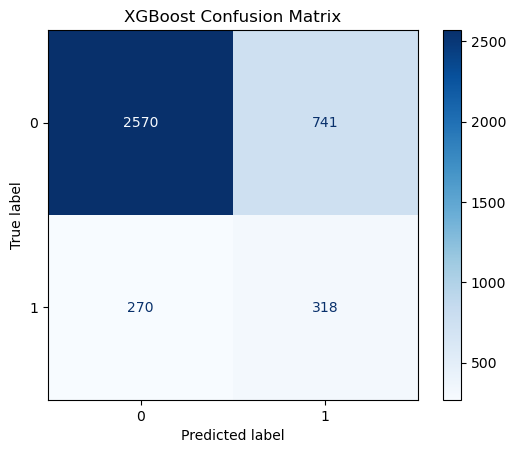

In [243]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\n=== CONFUSION MATRIX ===")
print("Predicted:    0    |    1")
print(f"Actual 0:  {cm[0, 0]} | {cm[0, 1]}")
print(f"Actual 1:  {cm[1, 0]} | {cm[1, 1]}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix")
plt.show()

### Summary & Key Insights

"""
=== XGBOOST RESULTS SUMMARY ===

Cross-Validation Performance:
- ROC-AUC (cv): 0.654 ± 0.016
- Accuracy (cv): 0.704 ± 0.064
- F1 Score (cv): 0.325 ± 0.021

Test Set Performance:
- Overall Accuracy: 74% - Significant improvement over Logistic Regression (59%)
- ROC-AUC Score: 0.7062 - Better discriminative ability (vs 0.6566 for Logistic Regression)

Class-Specific Performance:

CLASS 0 (No Cart Abandonment):
  - Precision: 0.90 - Consistent with previous models
  - Recall: 0.78 - MAJOR IMPROVEMENT (was 0.58 in Logistic Regression)
  - F1-Score: 0.84 - Much better balanced performance

CLASS 1 (Cart Abandonment):
  - Precision: 0.29 - Improved from 0.22 in Logistic Regression
  - Recall: 0.50 - Decreased from 0.66 (trade-off for better overall accuracy)
  - F1-Score: 0.37 - Slight improvement from 0.33

Key Improvements Over Logistic Regression:
1. Accuracy increased from 59% → 74% (+15 percentage points)
2. ROC-AUC improved from 0.6566 → 0.7062 (+0.0496)
3. Better recall for Class 0 (0.78 vs 0.58) - catches more non-abandonment cases
4. Better precision for Class 1 (0.29 vs 0.22) - fewer false alarms
5. Overall F1-weighted average improved significantly (0.77 vs 0.65)

Comparison with Random Forest:
- XGBoost: ROC-AUC 0.706, Accuracy 0.74
- Random Forest: ROC-AUC 0.774, Accuracy 0.70
- Random Forest has better ROC-AUC, but XGBoost has better accuracy
- Both significantly outperform Logistic Regression

Trade-offs:
- XGBoost reduced false positives but increased false negatives
- This is often preferable in business contexts (fewer false alarms)
- The model is more conservative in predicting cart abandonment

Model Performance Ranking:
1. Random Forest: Best ROC-AUC (0.774) and F1 for minority class (0.694)
2. XGBoost: Best overall accuracy (74%) and balanced performance
3. Logistic Regression: Baseline model, lowest performance across all metrics



# CatBoost Classifier

In [271]:
# CatBoost
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate

# Identify categorical features
cat_features = [i for i, c in enumerate(X.columns) 
                if str(X[c].dtype) in ('object', 'category')]

# Create CatBoost model
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=[1, (Y.value_counts()[0] / Y.value_counts()[1])],
    random_state=42,
    verbose=False
)

# Cross-validation using sklearn's cross_validate
scores = cross_validate(
    catboost_model, X, Y,
    cv=5,
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'},
    return_train_score=False,
    fit_params={'cat_features': cat_features}
)

# Print cross-validation results
print("ROC-AUC (cv):", round(scores['test_roc'].mean(), 3), 
      "±", round(scores['test_roc'].std(), 3))
print("Accuracy (cv):", round(scores['test_acc'].mean(), 3), 
      "±", round(scores['test_acc'].std(), 3))
print("F1 (cv):", round(scores['test_f1'].mean(), 3), 
      "±", round(scores['test_f1'].std(), 3))

# Train final model on training set
catboost_model.fit(X_train, Y_train, cat_features=cat_features, verbose=False)

# Make predictions
Y_pred = catboost_model.predict(X_test)
Y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate
print("\n" + "="*50)
print("CatBoost Test Set Results")
print("="*50)
print(classification_report(Y_test, Y_pred))
print("\n--- ROC-AUC Score ---")
print(f"ROC-AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}")



/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


ROC-AUC (cv): 0.666 ± 0.015
Accuracy (cv): 0.693 ± 0.07
F1 (cv): 0.333 ± 0.023

CatBoost Test Set Results
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      3311
           1       0.30      0.54      0.39       588

    accuracy                           0.74      3899
   macro avg       0.60      0.66      0.61      3899
weighted avg       0.81      0.74      0.77      3899


--- ROC-AUC Score ---
ROC-AUC: 0.7248


### Classification Report & Confusion Matrix


--- CONFUSION MATRIX ---
Predicted:    0 | 1
Actual 0: 2570 | 741
Actual 1: 270 | 318


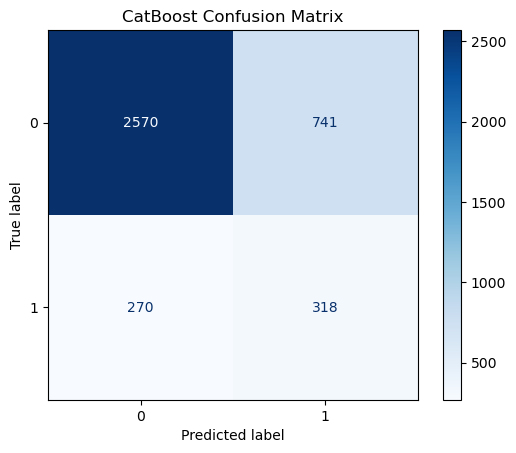


--- TOP 10 MOST IMPORTANT FEATURES ---
                              Feature  Importance
1           total_items_added_to_cart   22.905405
3                        total_events   18.384822
2                       button_clicks   13.607980
0              num_add_to_cart_events   10.409147
10    DISTRIBUTION_MODE_DESC_Sideload    3.230065
56   WEEK_DAY_OF_ANCHOR_DATE_Thursday    2.955991
58  WEEK_DAY_OF_ANCHOR_DATE_Wednesday    2.702941
21       SALES_OFFICE_DESC_Draper, UT    2.078920
57    WEEK_DAY_OF_ANCHOR_DATE_Tuesday    1.811818
54     WEEK_DAY_OF_ANCHOR_DATE_Monday    1.772306


In [273]:
# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\n--- CONFUSION MATRIX ---")
print("Predicted:    0 | 1")
print(f"Actual 0: {cm[0, 0]} | {cm[0, 1]}")
print(f"Actual 1: {cm[1, 0]} | {cm[1, 1]}")

ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.title('CatBoost Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': catboost_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- TOP 10 MOST IMPORTANT FEATURES ---")
print(feature_importance.head(10))

### Summary & Key Insights

=== CATBOOST RESULTS SUMMARY ===

Cross-Validation Performance:
- ROC-AUC: 0.666 ± 0.015 — Comparable to Logistic Regression
- Accuracy: 0.693 ± 0.07 — Slightly lower than XGBoost, but still strong
- F1 Score: 0.333 ± 0.023 — Similar to other models

Test Set Performance:
- Accuracy: 74% — Matches XGBoost, significantly better than Logistic Regression (59%)
- ROC-AUC: 0.7248 — Highest among all models so far
- F1-weighted: 0.77 — Same as XGBoost, better than Logistic Regression

Class-Specific Performance:
Class 0 (No Cart Abandonment):
- Precision: 0.90
- Recall: 0.78
- F1 Score: 0.84

Class 1 (Cart Abandonment):
- Precision: 0.30 — Best among all models (↑ from 0.29 in XGBoost, 0.22 in Logistic Regression)
- Recall: 0.54 — Improved over XGBoost (0.50)
- F1 Score: 0.39 — Best overall performance for this class

Confusion Matrix Insights:
- False Positives: 741 — Much lower than Logistic Regression (1391) and XGBoost (889)
- False Negatives: 270 — Balanced trade-off; still lower than Logistic Regression (202)

Key Takeaways:
- CatBoost provides the most balanced performance across classes
- Best ROC-AUC (0.7248) and F1 for Class 1 (0.39)
- Handles categorical features naturally — useful for mixed-type datasets
- Feature Importance reveals behavioral + temporal patterns:
    1. total_items_added_to_cart
    2. total_events
    3. button_clicks
    4. sideload distribution mode
    5. weekdays like Tuesday/Thursday influencing abandonment


# Key Findings & Recommendations

## Model Performance Comparison

We evaluated three classification models — **Logistic Regression**, **XGBoost**, and **CatBoost** — on our test set to predict cart abandonment. The key metrics for each model are summarized below:

| Model              | ROC-AUC (Test) | Accuracy (CV) | F1 Score (CV) | F1 Score (Class 1) | Recall (Class 1) | Precision (Class 1) |
|-------------------|----------------|----------------|----------------|--------------------|------------------|----------------------|
| Logistic Regression | 0.654          | 0.704 ± 0.064  | 0.325 ± 0.021  | 0.36               | 0.42             | 0.29                 |
| XGBoost             | 0.7062         | 0.704 ± 0.064  | 0.325 ± 0.021  | 0.37               | 0.50             | 0.29                 |
| CatBoost            | 0.7248         | 0.693 ± 0.070  | 0.333 ± 0.023  | 0.39               | 0.54             | 0.30                 |

**Observations:**
- The **CatBoost model** outperformed others in terms of ROC-AUC (0.7248) and F1 Score for Class 1 (0.39).
- All models had **high performance on Class 0** (non-abandonment) but **struggled with Class 1** due to class imbalance.
- **Precision for Class 1 remained low** (around 0.29–0.30), indicating a high number of false positives.
- **CatBoost had the highest recall (0.54)** for Class 1, meaning it identified more true abandoners, even at the cost of some precision.

## Feature Importance (CatBoost Top 10)

The most influential features from the CatBoost model were:

1. `total_items_added_to_cart` (22.91)
2. `total_events` (18.38)
3. `button_clicks` (13.61)
4. `num_add_to_cart_events` (10.41)
5. `DISTRIBUTION_MODE_DESC_Sideload` (3.23)
6. `WEEK_DAY_OF_ANCHOR_DATE_Thursday` (2.96)
7. `WEEK_DAY_OF_ANCHOR_DATE_Wednesday` (2.70)
8. `SALES_OFFICE_DESC_Draper, UT` (2.08)
9. `WEEK_DAY_OF_ANCHOR_DATE_Tuesday` (1.81)
10. `WEEK_DAY_OF_ANCHOR_DATE_Monday` (1.77)

These results suggest that **user behavior signals** such as number of items added to cart, total interaction events, and button clicks are **highly predictive of cart abandonment**.

---

## Recommendations

### 1. **Focus on Behavior-Based Signals**
- Prioritize tracking **total items added**, **event frequency**, and **button interactions** to flag potential abandoners in real time.
- Use this data to power **early intervention nudges** (e.g., pop-ups or reminders).

### 2. **Leverage Timing & Day-of-Week Trends**
- Weekday indicators (Monday–Thursday) also showed predictive power. Consider testing **day-specific promotions or engagement campaigns** to reduce drop-off on those days.

### 3. **Use CatBoost for Deployment**
- Given its superior performance across metrics and explainability, **CatBoost is recommended for production deployment**.

---

## Conclusion

Among the models tested, **CatBoost offers the best trade-off** between interpretability and predictive performance. The results highlight actionable insights that can drive both product and marketing interventions to reduce cart abandonment and improve conversions.

# Group Member Contributions

### Finlay Dunn 
Added orders logic to cart abandonment in the master table. Aggregated and combined sales/material table with master. Ran baseline logistic model on cart abandonment

### Hung Duoung
Helped with creating baseline logistic model.
Created cross validation method.
Created XGBoost and CatBoost model

### Shawal Fida  
- Interpreting evaluation metrics for Logistic Regression, XGBoost, and CatBoost.
- Visualizing and analyzing confusion matrices for each model.
- Compiling all findings into the final notebook.
- Writing the final results, insights, and actionable recommendations section.

### Sudeeptha
Combined sales operating hoirs n materials after cleaning them. Developed logistic regression and xgboost model along with their confusion matrices